In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import time

import sys
sys.path.append("..")
from models import CATENet, ComplianceNet_OneStep

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 18

%matplotlib inline

# Representation Learning Simulation Example

1. **Confounded DGP:**
$$
X \sim N(0, 1)\\
A \sim Bern(0.5)\\
U \mid X=x, A=a \sim N\left(x\left(a-\frac{1}{2}\right), 1-\left(a-\frac{1}{2}\right)^2\right)\\
Y = 1 + A + X + 2AX + 0.5X^2 + 0.75AX^2 + U + 0.5\epsilon_Y, \quad \epsilon_Y \sim N(0, 1)
$$

2. **IV DGP:**
$$
X \sim N(0, 1), \quad Z \sim Bern(0.5), \quad A^* \sim Bern(0.5)\\
\gamma(X) = \sigma(2X), \quad C \sim Bern(\gamma(X))\\
A = C \cdot Z + (1-C) \cdot A^*\\
U \mid X=x, A=a \sim N\left(x\left(a-\frac{1}{2}\right), 1-\left(a-\frac{1}{2}\right)^2\right)\\
Y = 1 + A + X + 2AX + 0.5X^2 + 0.75AX^2 + U + 0.5\epsilon_Y, \quad \epsilon_Y \sim N(0, 1)
$$
where $\sigma(x) = \frac{1}{1+\exp(-x)}$.

In [2]:
def sigma(x):
    return 1/(1+np.exp(-x))

def y_func(x, a, u):
    return (1 + a + x + 2*a*x + 0.5*x**2 + 0.75*a*x**2 + u)

def true_tau(x):
    return 0.75*x**2 + 2*x + 1

In [3]:
# DGP parameters
n = 5000
X_test = np.arange(-3, 3, 0.01)

In [4]:
np.random.seed(1)
n_O = int(n*1.25)
n_E = n
# Observational data
X_O = np.random.normal(size=n_O, scale=1)
A_O = np.random.binomial(1, 0.5, size=n_O)
U_O = np.random.normal(X_O*(A_O-0.5), np.sqrt(1-(A_O-0.5)**2))
eps_O = np.random.normal(size=n_O)/2
Y_O = np.array([y_func(X_O[i], A_O[i], U_O[i]) for i in range(n_O)]) + eps_O

# Experimental data
X_E = np.random.normal(size=n_E, scale=1)
Z_E = np.random.binomial(1, 0.5, size=n_E)
gamma_X = np.vectorize(sigma)(2*X_E)
C = np.random.binomial(1, gamma_X)
A_star = np.random.binomial(1, 0.5, size=n_E)
A_E = C * Z_E + (1-C) * A_star
U_E = C*np.random.normal(size=n_E) + (1-C)*np.random.normal(X_E*(A_E-0.5), np.sqrt(1-(A_E-0.5)**2))
eps_E = np.random.normal(size=n_E)/2
Y_E = np.array([y_func(X_E[i], A_E[i], U_E[i]) for i in range(n_E)]) + eps_E

# Split observational data
X_O_train, X_O_val, A_O_train, A_O_val, Y_O_train, Y_O_val = train_test_split(X_O, A_O, Y_O, test_size=0.2, random_state=1)

### 1. Learn $\widehat{\tau}^O(x)$

In [5]:
# Learn observational tau
X_O_train_t = torch.tensor(X_O_train.reshape(-1, 1), dtype=torch.float).cuda()
A_O_train_t = torch.tensor(A_O_train, dtype=torch.float).cuda()
Y_O_train_t = torch.tensor(Y_O_train, dtype=torch.float).cuda()

X_O_val_t = torch.tensor(X_O_val.reshape(-1, 1), dtype=torch.float).cuda()
A_O_val_t = torch.tensor(A_O_val, dtype=torch.float).cuda()
Y_O_val_t = torch.tensor(Y_O_val, dtype=torch.float).cuda()

n_cov = 1
n_hidden = 5
d_hidden = 2
d_out = 2
tauO_nnet = CATENet(n_cov, n_hidden, d_hidden, d_out).cuda()
tauO_nnet.train_model(X_O_train_t, A_O_train_t, Y_O_train_t,
                      X_O_val_t, A_O_val_t, Y_O_val_t, batch_size=2000, lambda_y=0.01, learning_rate=0.01, patience=10, n_epochs=1000, verbose=False)
X_test_t = torch.tensor(X_test.reshape(-1, 1), dtype=torch.float)
y1, y0 = tauO_nnet.forward(X_test_t.cuda())
tauO_hat = (y1-y0).cpu().detach().numpy()

Early stopping


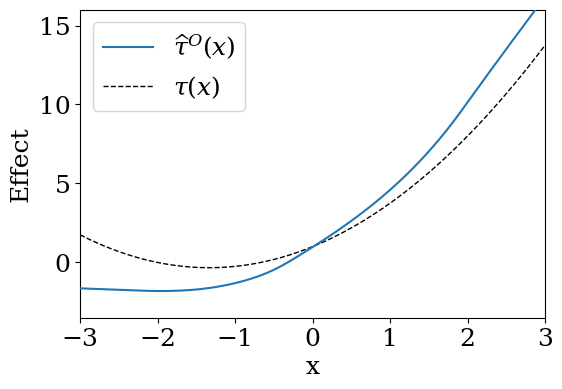

In [6]:
plt.figure(figsize=(6, 4))
plt.plot(X_test, tauO_hat, label=r"$\widehat{\tau}^O(x)$", color="C0", zorder=10)
plt.plot(X_test, np.vectorize(true_tau)(X_test), label=r"$\tau(x)$", color='black', ls='--', lw=1)
plt.xlabel("x")
plt.ylabel("Effect")
plt.ylim(-3.5, 16)
plt.xlim(-3, 3)
plt.legend()
plt.show()

### 2. Learn $\widehat{\tau}^E(x)$

In [7]:
n_cov = 1
n_hidden = 3
d_hidden = 2
d_out = 2

# Split observational data
X_E_train, X_E_val, Z_E_train, Z_E_val, A_E_train, A_E_val, Y_E_train, Y_E_val = train_test_split(X_E, Z_E, A_E, Y_E, test_size=0.20, random_state=1)

X_E_train_t = torch.tensor(X_E_train.reshape(-1, 1), dtype=torch.float).cuda()
Z_E_train_t = torch.tensor(Z_E_train, dtype=torch.float).cuda()
A_E_train_t = torch.tensor(A_E_train, dtype=torch.float).cuda()
Y_E_train_t = torch.tensor(Y_E_train, dtype=torch.float).cuda()

X_E_val_t = torch.tensor(X_E_val.reshape(-1, 1), dtype=torch.float).cuda()
Z_E_val_t = torch.tensor(Z_E_val, dtype=torch.float).cuda()
A_E_val_t = torch.tensor(A_E_val, dtype=torch.float).cuda()
Y_E_val_t = torch.tensor(Y_E_val, dtype=torch.float).cuda()

# Learn compliance
gamma_nnet = ComplianceNet_OneStep(n_cov, n_hidden, d_hidden, d_out).cuda()
gamma_nnet.train_model(X_E_train_t, 2* Z_E_train_t * A_E_train_t - 2* (1-Z_E_train_t) * A_E_train_t,
                      X_E_val_t, 2* Z_E_val_t * A_E_val_t - 2* (1-Z_E_val_t) * A_E_val_t, batch_size=2000, lambda_y=0.00, learning_rate=0.01, patience=10, n_epochs=1000, verbose=False)
gamma_hat = gamma_nnet.forward(X_test_t.cuda()).cpu().detach().numpy()

# Learn outcome models
tauE_nnet = CATENet(n_cov, n_hidden, d_hidden, d_out).cuda()
tauE_nnet.train_model(X_E_train_t, Z_E_train_t, Y_E_train_t,
                      X_E_val_t, Z_E_val_t, Y_E_val_t, batch_size=2000, lambda_y=0.05, learning_rate=0.01, patience=10, n_epochs=1000, verbose=False)
X_test_t = torch.tensor(X_test.reshape(-1, 1), dtype=torch.float)

y1, y0 = tauE_nnet.forward(X_test_t.cuda())
delta_y_hat = (y1-y0).cpu().detach().numpy()

tauE_hat = delta_y_hat / np.maximum(gamma_hat, 0.1)

Early stopping
Early stopping


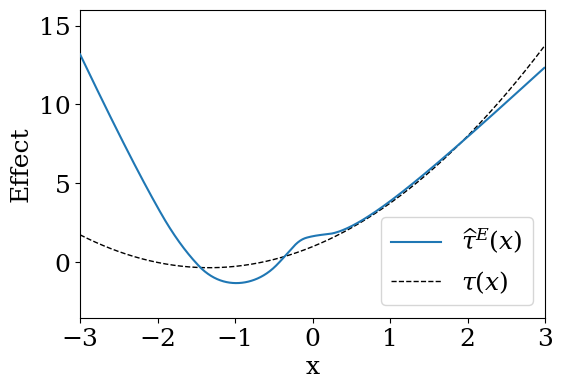

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(X_test, tauE_hat, label=r"$\widehat{\tau}^E(x)$", color="C0", zorder=10)
plt.plot(X_test, np.vectorize(true_tau)(X_test), label=r"$\tau(x)$", color='black', ls='--', lw=1)
plt.xlabel("x")
plt.ylabel("Effect")
plt.ylim(-3.5, 16)
plt.xlim(-3, 3)
plt.legend()
plt.show()

## 3. Apply Algorithm 2

In [9]:
X_E_t = torch.tensor(X_E.reshape(-1, 1), dtype=torch.float)

# Learn extension
y1_hat, y0_hat = tauO_nnet.forward(X_E_t.cuda())
tau_O_hat = (y1_hat-y0_hat).cpu().detach().numpy()
phi_X_E = tauO_nnet.rep.forward(X_E_t.cuda()).cpu().detach().numpy()
phi_X_test = tauO_nnet.rep.forward(X_test_t.cuda()).cpu().detach().numpy()

# First gamma model
pi1_z_model = RandomForestClassifier(max_depth=5, min_samples_leaf=50)
pi1_z_model.fit(X_E[Z_E==1].reshape(-1,1), A_E[Z_E==1])
pi0_z_model = RandomForestClassifier(max_depth=5, min_samples_leaf=50)
pi0_z_model.fit(X_E[Z_E==0].reshape(-1,1), A_E[Z_E==0])

gamma_X_hat_max = np.maximum((pi1_z_model.predict_proba(X_E.reshape(-1, 1))[:, 1] - pi0_z_model.predict_proba(X_E.reshape(-1, 1))[:, 1]), 0)

tilde_Y = 2*Y_E*Z_E - 2*Y_E*(1-Z_E) - gamma_X_hat_max*tau_O_hat
tilde_X = np.diag(gamma_X_hat_max) @ phi_X_E
lr = LinearRegression(fit_intercept=False).fit(tilde_X, tilde_Y)

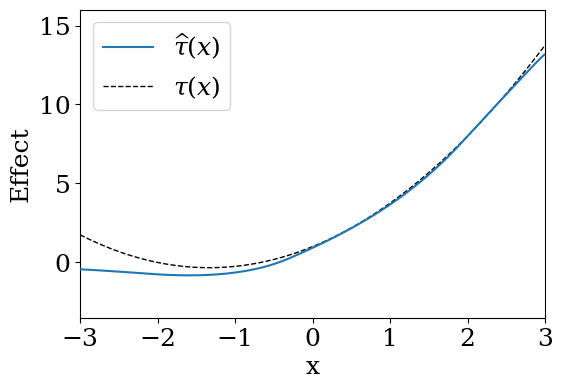

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(X_test, tauO_hat + lr.predict(phi_X_test), label=r"$\widehat{\tau}(x)$", color="C0", zorder=10)
plt.plot(X_test, np.vectorize(true_tau)(X_test), label=r"$\tau(x)$", color='black', ls='--', lw=1)
plt.xlabel("x")
plt.ylabel("Effect")
plt.ylim(-3.5, 16)
plt.xlim(-3, 3)
plt.legend()
plt.show()

In [11]:
# MSE calculations
oracle_tau = np.vectorize(true_tau)(X_test)
mse = np.sqrt(np.sum((tauO_hat - oracle_tau)**2)/X_test.shape[0])
print(f"tau_O RMSE: {mse:0.2f}.")

mse = np.sqrt(np.sum((tauE_hat - oracle_tau)**2)/X_test.shape[0])
print(f"tau_E RMSE: {mse:0.2f}.")

tau_hat = tauO_hat + lr.predict(phi_X_test)
mse = np.sqrt(np.sum((tau_hat - oracle_tau)**2)/X_test.shape[0])
print(f"tau_hat RMSE: {mse:0.2f}.")

tau_O RMSE: 1.77.
tau_E RMSE: 3.29.
tau_hat RMSE: 0.63.
